### Import Libraries

In [2]:
# import xgboost as xgb
import lightgbm as lgb
import pandas as pd
from sklearn import ensemble
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.multiclass import OneVsRestClassifier

sns.set_palette='Set2'
sns.set_style='ticks'
sns.despine()
%matplotlib inline

# https://www.kaggle.com/phanikiran99/titanic/basic-model-using-pandas-and-sklearn/comments
# https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/code
# http://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

### Read Data

In [3]:
X_train = pd.read_csv('data/train.csv', header=0)
X_test = pd.read_csv('data/test.csv', header=0)
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Clean Data
Fill NaN

In [4]:
def categorise_title(name):
    pattern = r', \w+'
    title = re.search(pattern, name).group(0)[2:]
    if title == 'Mr':
        return 0
    elif title == 'Master':
        return 1
    elif (title == 'Mrs' or title == 'Mme'):
        return 2
    elif (title == 'Miss' or title == 'Ms' or title == 'Mlle'):
        return 3
    else:
        return 4

def clean_up_df(df):
    """ This function will cleanup Age(Median), Sex(Change to 0,1), SibSp,Parch(Merge to Family), Embarked data
    Update to 'S' And Also deletes Name,Cabin details from titanic DF, Ensure to Pass DataFrame to this Function"""
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Gender'] = df['Sex'].map({'female':0, 'male':1}).astype(int)
    df['Family'] = df['Parch'] + df['SibSp']
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    df['Title'] = df['Name'].apply(categorise_title)
    df = df.drop(['SibSp','Parch','Sex','Name','Cabin','Embarked','Ticket'],axis=1)
    return df
clean_X_train = clean_up_df(X_train)
clean_X_test  = clean_up_df(X_test)

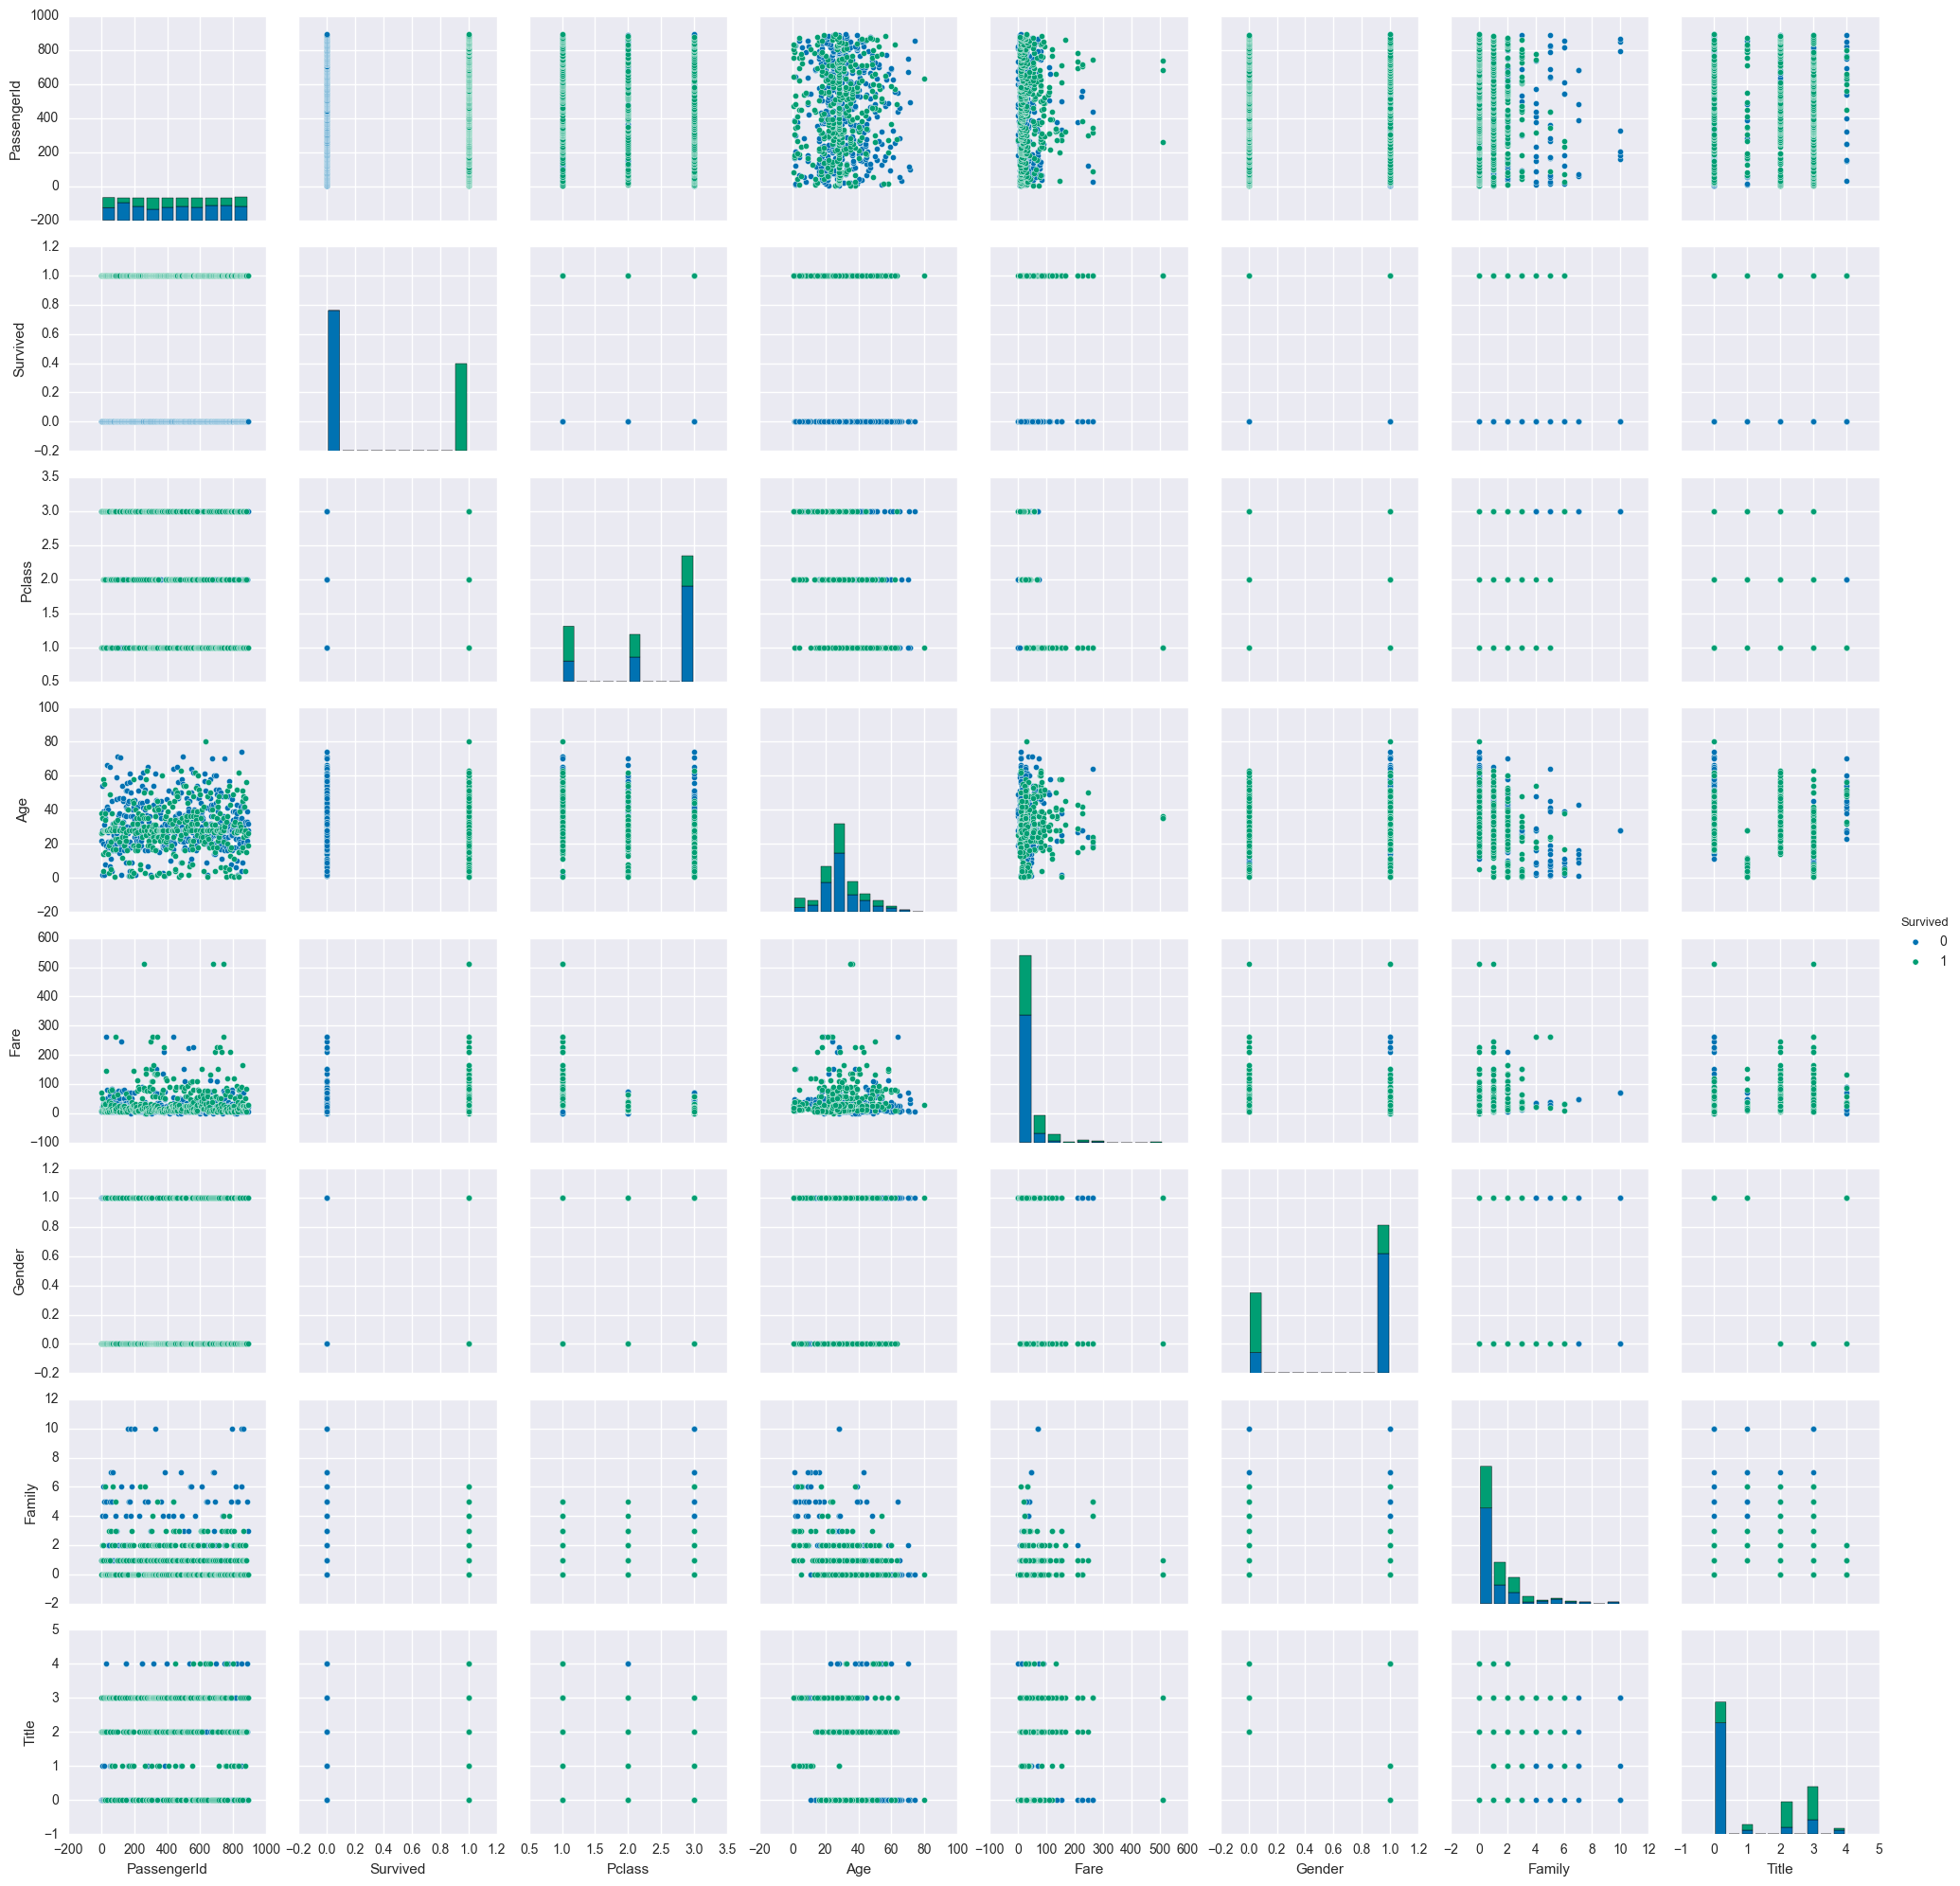

In [4]:
pp = sns.pairplot(clean_X_train, hue='Survived', palette='colorblind')

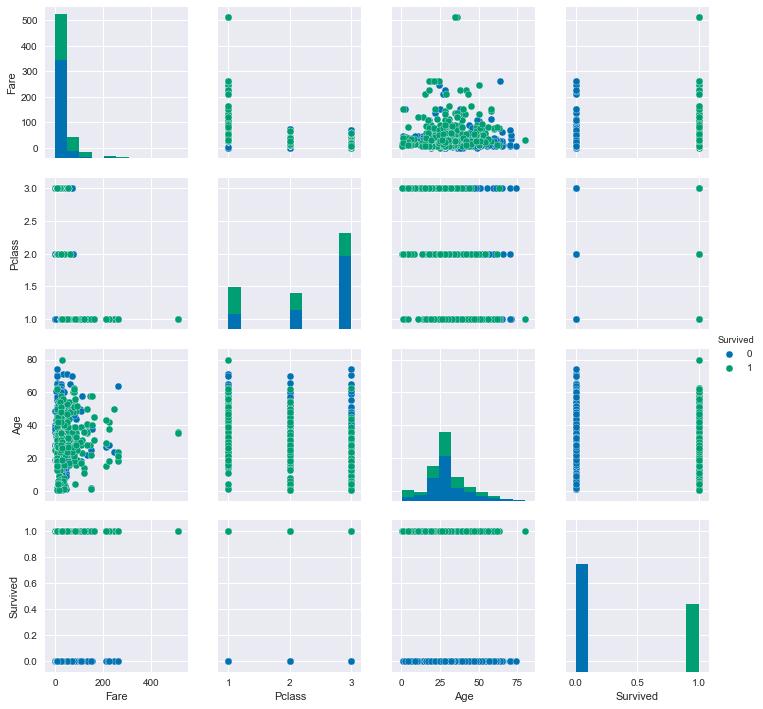

In [5]:
clean_X_train[['Age', 'Survived', 'Pclass']].head()
sns.pairplot(clean_X_train[['Fare', 'Pclass', 'Age', 'Survived']], hue='Survived', palette='colorblind')

# People who had higher fare and in first class survived most.

### Prepare X and Y

In [6]:
X = clean_X_train.drop(['PassengerId','Survived'],axis=1)
y = clean_X_train['Survived'].values

test_X_submission = clean_X_test.drop(['PassengerId'], axis=1)

In [7]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=341)

# XGBOOST

In [80]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.05).fit(train_X, train_y)
print('Training error:', gbm.score(train_X,train_y))
print('Test error:', gbm.score(test_X, test_y))
test_y_pred = gbm.predict_proba(test_X)

Training error: 0.906902086677
Test error: 0.865671641791


### Feature Importance

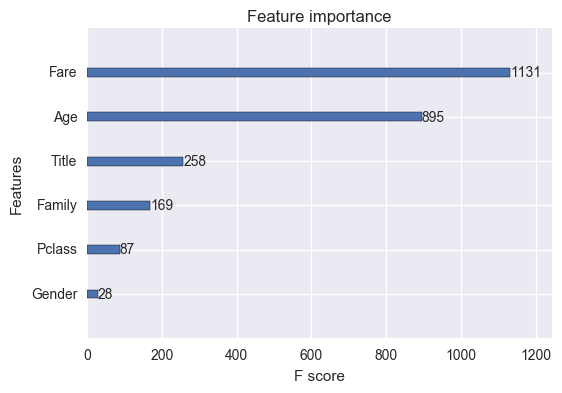

In [76]:
xgb.plot_importance(gbm)

## ROC Curve

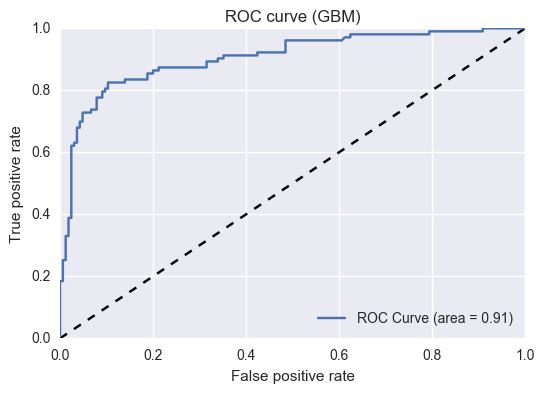

In [81]:
fpr_0, tpr_0, _= roc_curve(test_y, test_y_pred[:,0], pos_label=0)
fpr_1, tpr_1, _= roc_curve(test_y, test_y_pred[:,1], pos_label=1)
auc_ = auc(fpr_1, tpr_1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_0, tpr_0, label='Died')
plt.plot(fpr_1, tpr_1, label='ROC Curve (area = %0.2f)'%auc_)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (GBM)')
plt.legend(loc='best')
plt.show()

# Random Forest

In [69]:
random_forest = ensemble.RandomForestClassifier(n_estimators=100)
random_forest.fit(train_X, train_y)
print('Training Error:', random_forest.score(train_X, train_y))
print('Test Error:', random_forest.score(test_X, test_y))
test_y_pred = random_forest.predict_proba(test_X)

Training Error: 0.982343499197
Test Error: 0.850746268657


### Feature Importance

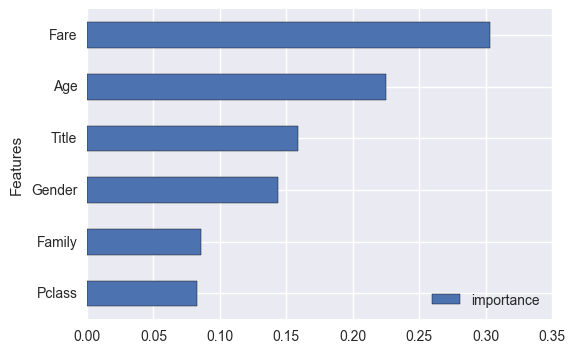

In [70]:
importances = pd.DataFrame({'Features':train_X.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance', ascending=True).set_index('Features')
importances.plot.barh()

### ROC Curve (Receiver Operating Characterstic)

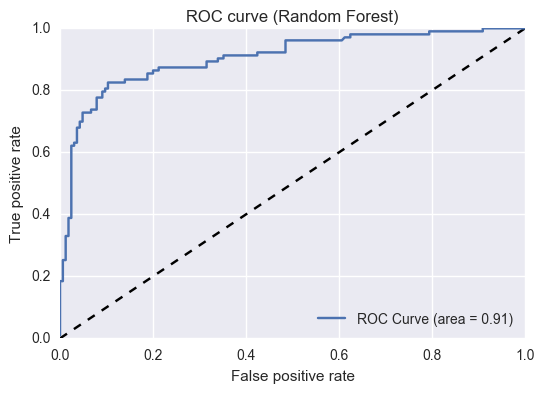

In [79]:
fpr_0, tpr_0, _= roc_curve(test_y, test_y_pred[:,0], pos_label=0)
fpr_1, tpr_1, _= roc_curve(test_y, test_y_pred[:,1], pos_label=1)
auc_ = auc(fpr_1, tpr_1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_0, tpr_0, label='Died')
plt.plot(fpr_1, tpr_1, label='ROC Curve (area = %0.2f)'%auc_)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (Random Forest)')
plt.legend(loc='best')
plt.show()

# LightGBM

In [42]:
lgbm = lgb.LGBMClassifier(
    num_leaves=10000,
    learning_rate=0.01,
    n_estimators=250)
lgbm.fit(train_X, train_y, categorical_feature='auto')
print('Training error:', lgbm.score(train_X,train_y))
print('Test error:', lgbm.score(test_X, test_y))
test_y_pred = lgbm.predict_proba(test_X)

# print(lgbm.evals_result_)

Training error: 0.869983948636
Test error: 0.85447761194


### Feature Importance

Plot feature importances...


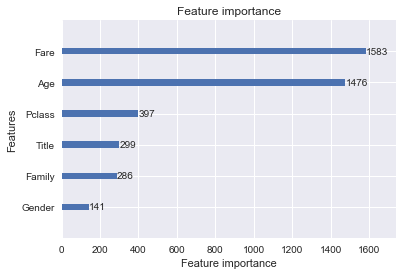

In [45]:
# print('Plot metrics during training...')
# ax = lgb.plot_metric(lgbm.evals_result, metric='l1')
# plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(lgbm, max_num_features=10)
plt.show()

# print('Plot 84th tree...')  # one tree use categorical feature to split
# ax = lgb.plot_tree(lgbm, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
# plt.show()


### ROC Curve

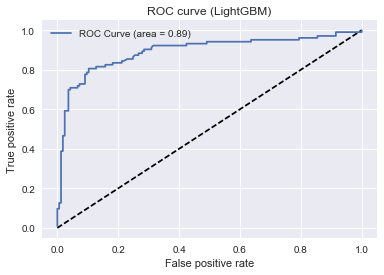

In [27]:
fpr_0, tpr_0, _= roc_curve(test_y, test_y_pred[:,0], pos_label=0)
fpr_1, tpr_1, _= roc_curve(test_y, test_y_pred[:,1], pos_label=1)
auc_ = auc(fpr_1, tpr_1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_0, tpr_0, label='Died')
plt.plot(fpr_1, tpr_1, label='ROC Curve (area = %0.2f)'%auc_)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (LightGBM)')
plt.legend(loc='best')
plt.show()